# Maximum-Cut Problem using Variants of Quantum Approximate Optimization Algorithm (QAOA), a small illustration of QiboOpt

## Maximum-Cut Problem


The **Maximum-Cut Problem** (MCP) can be stated as follows:

> Given a graph G = (V, E) with vertices V and edges E (possibly weighted), the Maximum-Cut Problem seeks to divide the set of verticies into two complementary subsets such that the total weight (or number) of edges between these subsets is maximised.

### Key Points:

1. **Combinatorial Nature:** For a graph with $n$ nodes, there are $2^{n-1} - 1$ possible unique cuts (since swapping the two sets produces the same cut). This exonential growth makes MCP computtionally hard for large $n$.

2. **Applications:**
    - **Machine Learning:**  
  The Maximum-Cut Problem (MCP) can be reformulated as an optimisation over binary variables, making it useful for tasks such as binary classification and clustering.

    - **Statistical / Theoretical Physics:**  
  MCP is closely related to minimising the **Hamiltonian** of spin glass systems.  
  *By negating the edge weights, a minimisation problem can be transformed into a maximisation one — and vice versa.*

    - **Network Design & Circuit Layout:**  
  It also arises in applications such as community detection, VLSI (Very Large-Scale Integration) circuit layout optimisation, and social network analysis.


3. **Optimisation Goal:** The objective is to maximise the total weight of the edges crossing the cut.

Here is a $5$-person example where we must split people into two groups to minimise within-group conflict. Equivalently, to maximise the total “conflict” cut. We model pairwise incompatibility with a symmetric weight matrix $W$ (higher = more tension), i.e. an undirected weighted graph:

$$
\mathbf{W} =
\begin{bmatrix}
0 & 0.2 & 0.8 & 0.8 & 0.8 \\
0.2 & 0 & 0.8 & 0.8 & 0.8 \\
0.8 & 0.8 & 0 & 0.2 & 0.2 \\
0.8 & 0.8 & 0.2 & 0 & 0.2 \\
0.8 & 0.8 & 0.2 & 0.2 & 0
\end{bmatrix}
$$

The $(i,j)$ entry gives the incompatibility between people $i$ and $j$. It is important to note that the matrix has zero diagonal and is symmetric $(W_{ij} = W_{ji})$.

Let's visualise this:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

dist_matrix = np.array([
    [0, 0.2, 0.8, 0.8, 0.8],
    [0.2, 0, 0.8, 0.8, 0.8],
    [0.8, 0.8, 0, 0.2, 0.2],
    [0.8, 0.8, 0.2, 0, 0.2],
    [0.8, 0.8, 0.2, 0.2, 0]
])

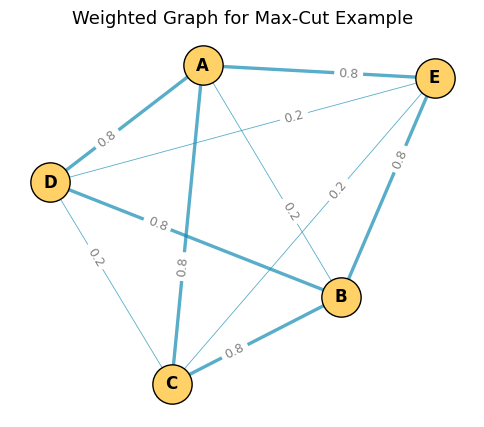

In [ ]:
# Create a weighted undirected graph from the matrix
G = nx.from_numpy_array(dist_matrix)

# Relabel nodes (A,B,C,D,E)
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
G = nx.relabel_nodes(G, mapping)

# Draw nodes and edges
pos = nx.spring_layout(G, seed=42, weight='weight', k=0.6)
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G, pos, node_color='#ffd166', node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Edge widths and colors proportional to weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(
    G, 
    pos, 
    width=[3*w for w in weights], 
    alpha=0.7, 
    edge_color='#118ab2'
    )

# Label edges with weights
edge_labels = {(u,v): f"{G[u][v]['weight']:.1f}" for u,v in G.edges()}
nx.draw_networkx_edge_labels(
    G, 
    pos, 
    edge_labels=edge_labels, 
    font_size=9, 
    font_color='gray',
    label_pos=0.64 
    )

# Output Graph
plt.title("Weighted Graph for Max-Cut Example", fontsize=13)
plt.axis('off')
plt.show()


By splitting the verticies into the sets $S = \{A, B\}$ and $S' = \{C, D, E\}$, the edges with the higher values (0.8) are cut. This configuration therefore yields a maximum cut, as it maximises the total weight of edges crossing between the two subsets.

In this tutorial, we will explore a similar max-cut instance and demostrate that the optimal partition can be identified in a small, illustrative example using the Quantum Approximate Optimisation Algorithm. This serves as a proof-of-concept showing how MCP can be formulated as a QUBO using Qibo.

## Encoding of the Maximum Cut Objective as a Quadratic Unconstrained Binary Optimisation (QUBO) Problem